In [1]:
# multivariate multi-step encoder-decoder lstm example
import os
import time
import random

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import keras
from keras.utils import Sequence
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Dropout, Flatten 
from keras.layers import Conv1D, Conv2D, MaxPooling2D
from keras.layers.convolutional import MaxPooling1D

Using TensorFlow backend.


### Define functions we'll need throughout

In [2]:
def normalizeVector(x,y,z,magnitude):
    return x/magnitude, y/magnitude, z/magnitude

In [3]:
def readCSV(dir,files):

    count = 0
    for file in files:
              
        x = []
        y = []
        z = []
        openFile = open(dir + file, "r")
        for line in openFile:
            parts = line.split(",")
            x.append(float(parts[0]))
            y.append(float(parts[1]))
            z.append(float(parts[2]))
        openFile.close()
        
        x = np.array(x)
        y = np.array(y)
        z = np.array(z)
        b = np.sqrt( x*x + y*y + z*z )
        #x, y, z = normalizeVector(x, y, z, b)
        x, y, z = normalizeVector(x, y, z, 40)
        
        if ( count == 0 ):
            bx, by, bz = x, y, z
        else:
            bx = np.vstack((bx,x))
            by = np.vstack((by,y))
            bz = np.vstack((bz,z))
            
        count += 1
        
    return bx, by, bz

In [4]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [5]:
def makeNpzFiles(csvP, npzP, fileList, stepSize):
    
    # make sure there are no npz files left over from a previous run
    c = 0
    for filename in os.listdir(npzP):
        file_path = os.path.join(npzP, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
                c += 1
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

    print("Deleted", c, "npz files in", npzP)
        
    loops = int(np.ceil(len(fileList)/stepSize))
    index1 = 0
    index2 = stepSize
    numFiles = 0
    for l in range(loops):
        files = fileList[index1:index2]
        bx, by, bz = readCSV(csvP, files)
        if (l < 10):
            counter = '00' + str(l)
        elif ( (l >= 10) and (l < 100) ):
            counter = '0' + str(l)
        else:
            counter = str(l)
        outfile = npzP + 'fluxropes_' + counter + '.npz'
        np.savez(outfile, bx=bx, by=by, bz=bz)
        index1 = index2
        index2 += stepSize
        numFiles += 1
    print("Created", numFiles, "npz files in", npzP)

In [6]:
def makeSequences(files, npzP, path):
    
    # make sure there are no npz files left over from a previous run
    c = 0
    p = npzP+path+'_sequences/'
    for filename in os.listdir(p):
        file_path = os.path.join(p, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
                c += 1
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

    print("Deleted", c, "npz files in", p)
    
    for file in files:
        
        npzfile = np.load(npzP + path + '/' + file)
        bx = npzfile['bx']
        by = npzfile['by']
        bz = npzfile['bz']
        
        n1 = bx.shape[0]
        n2 = bx.shape[1]
        for i in range( n1 ):
            
            in_seq1 = bx[i,:].reshape((n2, 1))
            in_seq2 = by[i,:].reshape((n2, 1))
            in_seq3 = bz[i,:].reshape((n2, 1))
            dataset = np.hstack((in_seq1,in_seq2,in_seq3))
    
            # covert into input/output
            xc, yc = split_sequences(dataset, n_steps_in, n_steps_out)
    
            if ( i == 0 ):
                x, y = xc, yc
            else:
                x = np.concatenate((x,xc))
                y = np.concatenate((y,yc))
            
            
        parts = file.split('_')
        parts = parts[1].split('.')
        counter = parts[0].strip()
    
        outfile = npzP + path + '_sequences/fluxropes_sequences_' + counter + '.npz'
        np.savez(outfile, x=x, y=y)
        
    print("Completed",path,"sequence generation")
    

### Configuration variables and path setup

In [141]:
csvPath = "/data/lstm/csv_teressa/"
npzPath = "/data/lstm/npz/"

n_features = 3 # bx, by, and bz
n_steps_in, n_steps_out = 16, 8

### Split the data into training, testing, and validation

In [142]:
allFiles = [f for f in os.listdir(csvPath) if os.path.isfile(os.path.join(csvPath, f))]
random.shuffle(allFiles)

In [143]:
# Distribution is 60% Training, 20% Validation, and 20% Testing
cutOff = int(len(allFiles) * 0.6)
train = allFiles[:cutOff]
rest = allFiles[cutOff:]

# there's 40% left over, split it in half for testing and validation
test = rest[ : int(len(rest) * 0.5)]
validation = rest[ int(len(rest) * 0.5) : ]

print("Training files:", len(train))
print("Test files:", len(test))
print("Validation files:", len(validation))
print()
print("Total number of files:", len(allFiles))

# check to make sure we split everything correctly
total = len(test) + len(train) + len(validation)
assert total == len(allFiles)

Training files: 536659
Test files: 178886
Validation files: 178887

Total number of files: 894432


### Write the names of the test files to disk for later evaluations

In [144]:
filename = '/data/lstm/models/test_file_list.txt'
fout = open(filename,'w')
for file in test:
    line = file.strip() + "\n"
    fout.write(line)
fout.close()

### Create npz files of training, testing, and validation to speed up network

In [145]:
startTime = time.time()

makeNpzFiles(csvPath, npzPath+'testing/', test, 1600)
makeNpzFiles(csvPath, npzPath+'training/', train, 1600)
makeNpzFiles(csvPath, npzPath+'validation/', validation, 1600)

# arrays now points to npz files
test = [f for f in os.listdir(npzPath+'testing/') if \
        os.path.isfile(os.path.join(npzPath+'testing/', f))]
train = [f for f in os.listdir(npzPath+'training/') if \
        os.path.isfile(os.path.join(npzPath+'training/', f))]
validation = [f for f in os.listdir(npzPath+'validation/') if \
        os.path.isfile(os.path.join(npzPath+'validation/', f))]

# convert from lists to numpy arrays
test = np.array(test)
train = np.array(train)
validation = np.array(validation)

stopTime = time.time()
duration = stopTime-startTime
print()
print("Data generation:", round(duration/60, 2), "minutes")

Deleted 112 npz files in /data/lstm/npz/testing/
Created 112 npz files in /data/lstm/npz/testing/
Deleted 336 npz files in /data/lstm/npz/training/
Created 336 npz files in /data/lstm/npz/training/
Deleted 112 npz files in /data/lstm/npz/validation/
Created 112 npz files in /data/lstm/npz/validation/

Data generation: 3.22 minutes


### Sanity check - Load and visualize one of the fluxrope

In [68]:
npzfile = np.load( npzPath + 'training/fluxropes_001.npz' )
bx = npzfile['bx']
by = npzfile['by']
bz = npzfile['bz']

# 50 points per fluxrope and 1600 fluxropes per npz file
assert bx.shape[0] == 1600
assert bx.shape[1] == 50 

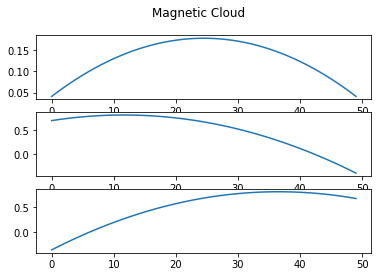

In [85]:
n = bx.shape[1]
x = np.arange(0,n)

fig, axs = plt.subplots(3)
fig.suptitle('Magnetic Cloud')
axs[0].plot(x, bx[0,:])
axs[1].plot(x, by[0,:])
axs[2].plot(x, bz[0,:])

### Create sequences

In [146]:
startTime = time.time()

# train
makeSequences(train, npzPath, 'training')
    
# validation
makeSequences(validation, npzPath, 'validation')
    
# testing
makeSequences(test, npzPath, 'testing')

# arrays now points to npz sequence files
test = [f for f in os.listdir(npzPath+'testing_sequences/') if \
        os.path.isfile(os.path.join(npzPath+'testing_sequences/', f))]

train = [f for f in os.listdir(npzPath+'training_sequences/') if \
        os.path.isfile(os.path.join(npzPath+'training_sequences/', f))]

validation = [f for f in os.listdir(npzPath+'validation_sequences/') if \
        os.path.isfile(os.path.join(npzPath+'validation_sequences/', f))]

stopTime = time.time()
duration = stopTime-startTime
print()
print("Sequence generation:", round(duration/60., 2), "minutes")

Deleted 336 npz files in /data/lstm/npz/training_sequences/
Completed training sequence generation
Deleted 112 npz files in /data/lstm/npz/validation_sequences/
Completed validation sequence generation
Deleted 112 npz files in /data/lstm/npz/testing_sequences/
Completed testing sequence generation

Sequence generation: 13.96 minutes


### Data reader

In [209]:
class NpzDataGenerator(Sequence):
    
    def __init__(self, d, files, batch_size=1, shuffle=False):
        
        self.batch_size = batch_size
        self.files = files
        self.dir = d
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        
        'Denotes the number of batches per epoch'

        'If the batch size doesnt divide evenly then add 1'
        diff = (len(self.files) / self.batch_size) - np.floor((len(self.files) / self.batch_size))
        if ( diff > 0 ):
            return int(np.floor(len(self.files) / self.batch_size))+1
        else:
            return int(np.floor(len(self.files) / self.batch_size))

    def __getitem__(self, index):
        
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # get list of files
        #files = [self.files[k] for k in indexes]
        file = self.files[indexes[0]]
        
        # Generate data
        npzfile = np.load(self.dir + file)
        x = npzfile['x']
        y = npzfile['y']
        
        #x = x[:,:,0]
        #y = y[:,:,0]
        #x = x.reshape( x.shape[0], x.shape[1], 1 )
        #y = y.reshape( y.shape[0], y.shape[1], 1 )
        
        y1 = y[:,:,0].reshape((y.shape[0], y.shape[1]))
        y2 = y[:,:,1].reshape((y.shape[0], y.shape[1]))
        y3 = y[:,:,2].reshape((y.shape[0], y.shape[1]))
        
        x = x[:,:,2]
        x = x.reshape( x.shape[0], x.shape[1], 1 )
        return x, y3 #[y1, y2, y3]

    def on_epoch_end(self):
        
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.files))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

### Train the model

In [26]:
# define model

n_outputs = 32
input_shape = (8, 3)

def get_model():
    
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(100, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(50, activation='relu')))
    model.add(TimeDistributed(Dense(3)))
    model.compile(loss='mse', optimizer='adam')
    
    return model

In [101]:
# define model

n_outputs = 32
input_shape = (8, 3)

def get_model():
    
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    #model.add(RepeatVector(n_outputs))
    #model.add(LSTM(100, activation='relu', return_sequences=True))
    #model.add(TimeDistributed(Dense(50, activation='relu')))
    #model.add(TimeDistributed(Dense(1)))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(32))
    model.compile(loss='mse', optimizer='adam')
    
    return model

In [210]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# define model

input_shape = (n_steps_in, 1)

def get_model():
    
    visible = Input(shape=input_shape)
    cnn = Conv1D(filters=64, kernel_size=3, activation='relu')(visible)
    #cnn = Conv1D(filters=64, kernel_size=3)(cnn)
    cnn = MaxPooling1D(pool_size=2)(cnn)
    cnn = Flatten()(cnn)
    cnn = Dense(50, activation='relu')(cnn)
    
    # define output 1
    output1 = Dense(n_steps_out)(cnn)
    # define output 2
    #output2 = Dense(n_steps_out)(cnn)
    # define output 3
    #output3 = Dense(n_steps_out)(cnn)
    
    #model = Model(inputs=visible, outputs=[output1, output2, output3])
    model = Model(inputs=visible, outputs=output1)
    model.compile(loss='mse', optimizer='adam')
    
    return model

In [211]:
# clear out any old models hanging around
keras.backend.clear_session()

trainGen = NpzDataGenerator(npzPath+'training_sequences/', train)
valGen = NpzDataGenerator(npzPath+'validation_sequences/', validation)
    
# define model
model = get_model()

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 14, 64)            256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 448)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                22450     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 408       
Total params: 23,114
Trainable params: 23,114
Non-trainable params: 0
_______________________________________________________

In [18]:
# This is required for my GPU: GeForce RTX 2060
# Without this config, tensorflow cannot properly allocate GPU memory
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

### Sanity check - do the sequences have the correct dimensions

In [152]:
nfile = np.load('/data/lstm/npz/training_sequences/fluxropes_sequences_108.npz')
t1 = nfile['x']
t2 = nfile['y']
print(t1.shape)
print(t2.shape)

(43200, 16, 3)
(43200, 8, 3)


In [212]:
# fit model

epochs = 100
model.fit_generator(trainGen, epochs=epochs, shuffle=False, verbose=1, validation_data=(valGen))

Epoch 1/100
336/336 [==============================] - 23s 68ms/step - loss: 0.0242 - val_loss: 0.0259
Epoch 2/100
336/336 [==============================] - 23s 69ms/step - loss: 0.0121 - val_loss: 0.0238
Epoch 3/100
336/336 [==============================] - 23s 69ms/step - loss: 0.0112 - val_loss: 0.0238
Epoch 4/100
336/336 [==============================] - 23s 69ms/step - loss: 0.0109 - val_loss: 0.0239
Epoch 5/100
336/336 [==============================] - 23s 69ms/step - loss: 0.0107 - val_loss: 0.0239
Epoch 6/100
336/336 [==============================] - 23s 69ms/step - loss: 0.0106 - val_loss: 0.0237
Epoch 7/100
336/336 [==============================] - 23s 69ms/step - loss: 0.0105 - val_loss: 0.0237
Epoch 8/100
336/336 [==============================] - 23s 68ms/step - loss: 0.0104 - val_loss: 0.0236
Epoch 9/100
336/336 [==============================] - 23s 69ms/step - loss: 0.0103 - val_loss: 0.0235
Epoch 10/100
336/336 [==============================] - 23s 68ms/step - l

Epoch 80/100
336/336 [==============================] - 23s 70ms/step - loss: 0.0092 - val_loss: 0.0221
Epoch 81/100
336/336 [==============================] - 23s 69ms/step - loss: 0.0092 - val_loss: 0.0222
Epoch 82/100
336/336 [==============================] - 23s 68ms/step - loss: 0.0092 - val_loss: 0.0221
Epoch 83/100
336/336 [==============================] - 23s 69ms/step - loss: 0.0092 - val_loss: 0.0221
Epoch 84/100
336/336 [==============================] - 23s 68ms/step - loss: 0.0092 - val_loss: 0.0221
Epoch 85/100
336/336 [==============================] - 23s 69ms/step - loss: 0.0092 - val_loss: 0.0221
Epoch 86/100
336/336 [==============================] - 23s 69ms/step - loss: 0.0092 - val_loss: 0.0221
Epoch 87/100
336/336 [==============================] - 23s 69ms/step - loss: 0.0092 - val_loss: 0.0221
Epoch 88/100
336/336 [==============================] - 23s 69ms/step - loss: 0.0092 - val_loss: 0.0221
Epoch 89/100
336/336 [==============================] - 23s 69ms

### Visualize the loss

Text(0.5, 1.0, 'Loss')

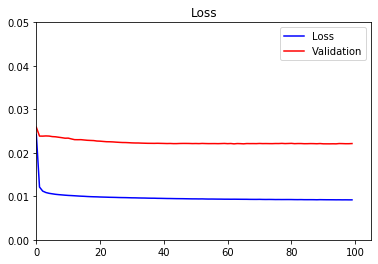

In [213]:
plt.plot(model.history.history['loss'], label="Loss", color='blue')
plt.plot(model.history.history['val_loss'], label="Validation", color='red')
plt.legend()
plt.xlim(0,105)
plt.ylim(0,.05)
plt.title('Loss')

### Evaluate on the test data

In [214]:
testGen = NpzDataGenerator(npzPath+'testing_sequences/', test)
mse = model.evaluate_generator(testGen, verbose=1)
print("Testing MSE:", mse)

112/112 [==============================] - 7s 62ms/step
Testing MSE: 0.0005700502078980207


### Make some predictions

In [215]:
nfile = np.load('/data/lstm/npz/training_sequences/fluxropes_sequences_001.npz')
t1 = nfile['x']
t2 = nfile['y']
#print(t1.shape)
print()

v = t1[12,:,:]
v = v[:,1]
#v = t1[12,:,0]

# demonstrate prediction
#x_input = v.reshape((1, n_steps_in, n_features))
x_input = v.reshape((1, n_steps_in, 1))
yhat = model.predict(x_input, verbose=0)

print("Predicted")
print(yhat)
print()
print("Actual")
print(t2[12,:,1])


Predicted
[[-0.02732979 -0.02742875 -0.02904062 -0.03139955 -0.03209557 -0.03250428
  -0.03073167 -0.03206921]]

Actual
[-0.03433954 -0.03520564 -0.03589947 -0.03642102 -0.0367703  -0.03694732
 -0.03695207 -0.03678455]


### Write model to a file

In [216]:
model.save_weights("/data/lstm/models/cnn_model_16in_8out_no_noise_z.h5")

### Visualize prediction

In [199]:
npzfile = np.load( npzPath + 'training/fluxropes_001.npz' )
bx = npzfile['bx']
#by = npzfile['by']
#bz = npzfile['bz']

# there are 1600 fluxropes in this npz file
# let's pick one to work with
ix = 122
bx_seq = bx[ix,0:n_steps_in]
#by_seq = by[ix,0:n_steps_in]
#bz_seq = bz[ix,0:n_steps_in]

in_seq1 = bx_seq.reshape((n_steps_in, 1))
#in_seq2 = by_seq.reshape((n_steps_in, 1))
#in_seq3 = bz_seq.reshape((n_steps_in, 1))
   
#dataset = np.hstack((in_seq1,in_seq2,in_seq3))
#dataset = dataset.reshape((1, n_steps_in, n_features))
#dataset = bx_seq
dataset = dataset.reshape((1, n_steps_in, 1))
yhat = model.predict(dataset, verbose=0)

bxp = yhat[0][0]
#byp = yhat[1][0]
#bzp = yhat[2][0]

n = bx[ix,:].shape[0]
x = np.arange(0, n)

fillValues = np.full(n_steps_in,float('NaN'))
#bx1 = np.concatenate( (fillValues, yhat[0,:]) )
bx1 = np.concatenate( (fillValues, bxp) )
#by1 = np.concatenate( (fillValues, byp) )
#bz1 = np.concatenate( (fillValues, bzp) )

fillValues = np.full(len(x)-bx1.shape[0],float('NaN'))
bx1 = np.concatenate( (bx1, fillValues) )
#by1 = np.concatenate( (by1, fillValues) )
#bz1 = np.concatenate( (bz1, fillValues) )

#xx = bx[ix,:]*40
#yy = by[ix,:]*40
#zz = bz[ix,:]*40
#b = np.sqrt( xx*xx + yy*yy + zz*zz )

#xx2 = bx1*40
#yy2 = by1*40
#zz2 = bz1*40
#b2 = np.sqrt( xx2*xx2 + yy2*yy2 + zz2*zz2 )

#b1 = np.sqrt( bx[ix,:]*bx[ix,:] + by[ix,:]*by[ix,:] + bz[ix,:]*bz[ix,:] )
#b2 = np.sqrt( bx1*bx1 + by1*by1 + bz1*bz1 )

#plt.subplot(4, 1, 1)
#plt.title('Magnetic Cloud Predictions')
#plt.plot(x, b1)
#plt.plot(x, b2, color='red', marker='.', linestyle='None' )
#plt.ylabel('B')
#plt.ylim(0,15)

#plt.subplot(4, 1, 2)
plt.plot(x, bx[ix,:])
plt.plot(x, bx1, color='red', marker='.', linestyle='None' )
plt.ylabel('Bx')
#plt.ylim(-1,1)

#plt.subplot(4, 1, 3)
#plt.plot(x, by[ix,:])
#plt.plot(x, by1, color='red', marker='.', linestyle='None' )
#plt.ylim(-35,35)
#plt.ylabel('By')

#plt.subplot(4, 1, 4)
#plt.plot(x/n, bz[ix,:])
#plt.plot(x/n, bz1, color='red', marker='.', linestyle='None' )
#plt.ylim(-35,35)
#plt.ylabel('Bz')

ValueError: cannot reshape array of size 48 into shape (1,16,1)

### Use the first set of predictions to make another set of predictions

Text(0, 0.5, 'Bz')

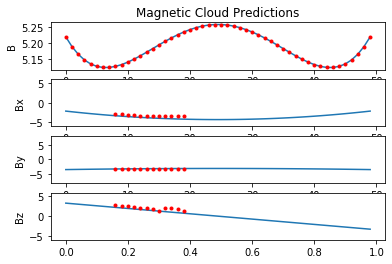

In [135]:
npzfile = np.load( npzPath + 'training/fluxropes_001.npz' )
bx = npzfile['bx']
by = npzfile['by']
bz = npzfile['bz']

# there are 1600 fluxropes in this npz file
# let's pick one to work with
ix = 12
bx_seq = bx[ix,0:n_steps_in]
by_seq = by[ix,0:n_steps_in]
bz_seq = bz[ix,0:n_steps_in]

in_seq1 = bx_seq.reshape((n_steps_in, 1))
in_seq2 = by_seq.reshape((n_steps_in, 1))
in_seq3 = bz_seq.reshape((n_steps_in, 1))
   
dataset = np.hstack((in_seq1,in_seq2,in_seq3))
dataset = dataset.reshape((1, n_steps_in, n_features))
yhat = model.predict(dataset, verbose=0)

n = bx[ix,:].shape[0]
x = np.arange(0, n)
fillValues = np.full(8,float('NaN'))

bx1 = np.concatenate( (bx_seq[-4:], yhat[0,:,0]) )
by1 = np.concatenate( (by_seq[-4:], yhat[0,:,1]) )
bz1 = np.concatenate( (bz_seq[-4:], yhat[0,:,2]) )

in_seq1 = bx_seq.reshape((n_steps_in, 1))
in_seq2 = by_seq.reshape((n_steps_in, 1))
in_seq3 = bz_seq.reshape((n_steps_in, 1))

dataset = np.hstack((in_seq1,in_seq2,in_seq3))
dataset = dataset.reshape((1, n_steps_in, n_features))
yhat = model.predict(dataset, verbose=0)

bx1 = np.concatenate( (bx1, yhat[0,:,0]) )
by1 = np.concatenate( (by1, yhat[0,:,1]) )
bz1 = np.concatenate( (bz1, yhat[0,:,2]) )

bx1 = np.concatenate( (fillValues, bx1) )
by1 = np.concatenate( (fillValues, by1) )
bz1 = np.concatenate( (fillValues, bz1) )

fillValues = np.full(len(x)-bx1.shape[0],float('NaN'))
bx1 = np.concatenate( (bx1, fillValues) )
by1 = np.concatenate( (by1, fillValues) )
bz1 = np.concatenate( (bz1, fillValues) )

xx = bx[ix,:]*40
yy = by[ix,:]*40
zz = bz[ix,:]*40
b = np.sqrt( xx*xx + yy*yy + zz*zz )

xx2 = bx1*40
yy2 = by1*40
zz2 = bz1*40
b2 = np.sqrt( xx*xx + yy*yy + zz*zz )

plt.subplot(4, 1, 1)
plt.title('Magnetic Cloud Predictions')
plt.plot(x, b)
plt.plot(x, b2, color='red', marker='.', linestyle='None' )
plt.ylabel('B')
#plt.ylim(-1,1)

plt.subplot(4, 1, 2)
plt.plot(x, xx)
plt.plot(x, xx2, color='red', marker='.', linestyle='None' )
plt.ylabel('Bx')
plt.ylim(-6,6)

plt.subplot(4, 1, 3)
plt.plot(x, yy)
plt.plot(x, yy2, color='red', marker='.', linestyle='None' )
plt.ylim(-8,8)
plt.ylabel('By')

plt.subplot(4, 1, 4)
plt.plot(x/n, zz)
plt.plot(x/n, zz2, color='red', marker='.', linestyle='None' )
plt.ylim(-6,6)
plt.ylabel('Bz')

In [38]:
12/50.

0.24

In [39]:
4*12

48